# IHLT Lab 4

Lab developed by:
- Oriol Miró López-Feliu
- Niklas Long Schiefelbein


**Exercice description:**
1. Consider Treebank corpus.
  - Train HMM, TnT, perceptron and CRF models using the first 500, 1000, 1500, 2000, 2500 and 3000 sentences.
  - Evaluate the resulting 24 models using sentences from 3001.

1. Provide a figure with four learning curves, each per model type (X=training set size; Y=accuracy).
  - Which model would you select? Justify the answer.

## Imports

In [1]:
!pip install python-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00


In [ ]:
# basic
import time
import nltk
nltk.download('treebank')

# install
!pip install python-crfsuite

# plotting
import matplotlib.pyplot as plt

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


## Useful Functions

In [ ]:
def split_data(df, train_size):
  return df[:train_size], df[3001:] # we always evaluate "using sentences from 3001"!

def LID(fd, bins):
    return nltk.probability.LidstoneProbDist(fd, 0.1, bins)

## Data Loading

In [ ]:
df = nltk.corpus.treebank.tagged_sents()

### Small EDA

In [ ]:
print(f"len: {len(df)}")
print(f"type: {type(df)}")
print(f"first few rows:")
display(df[:2])

len: 3914
type: <class 'nltk.corpus.reader.util.ConcatenatedCorpusView'>
first few rows:


[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')]]

## Learning the models
We must learn an HMM, a TnT, a perceptron and a CRF model for train sizes (500, 1000, 1200, 2000, 2500, 3000), yielding 4tx6=24 models.

After the first training loop, we realised there was numerical overflow on HMMs, caused by low probabilities; we will also train HMM with LID smoothing to redistribute probability mass and avoid overflow (underflow?). This will result in 5x6=30 models.

We also record the training time, as it is important to choose the best model.

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
train_sizes = [500, 1000, 1200, 2000, 2500, 3000]

results = {
    "HMM"       : [],
    "HMM_LID"   : [],
    "TnT"       : [],
    "CRF"       : [],
    "Perceptron": []
}

training_times = {
    "HMM"       : [],
    "HMM_LID"   : [],
    "TnT"       : [],
    "CRF"       : [],
    "Perceptron": []
}

inference_times = {
    "HMM"       : [],
    "HMM_LID"   : [],
    "TnT"       : [],
    "CRF"       : [],
    "Perceptron": []
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# TRAIN LOOP:

# we can not do a pretty double for loop because HMM's syntax differs from others :(
for train_size in train_sizes:
    train_data, test_data = split_data(df, train_size)

    print(f"\nTraining with {train_size} sentences")



    #  ----- Vanilla HMM -----
    trainer = nltk.tag.hmm.HiddenMarkovModelTrainer()

    # training time
    start_time    = time.time()
    HMM           = trainer.train_supervised(train_data)
    training_time = time.time() - start_time
    training_times["HMM"].append(training_time)

    # inference time
    start_time      = time.time()
    hmm_accuracy    = HMM.accuracy(test_data)
    inference_time  = time.time() - start_time
    inference_times["HMM"].append(inference_time)

    results["HMM"].append(hmm_accuracy)
    print(f"Vanilla HMM accuracy: {hmm_accuracy}, Training Time: {training_time:.2f} seconds, Inference Time: {inference_time:.2f} seconds")



    # ----- HMM with LID smoothing -----
    trainer = nltk.tag.hmm.HiddenMarkovModelTrainer()

    # training time
    start_time      = time.time()
    HMM_LID         = trainer.train_supervised(train_data, estimator=LID)
    training_time   = time.time() - start_time
    training_times["HMM_LID"].append(training_time)

    # inference time
    start_time        = time.time()
    hmm_lid_accuracy  = HMM_LID.accuracy(test_data)
    inference_time    = time.time() - start_time
    inference_times["HMM_LID"].append(inference_time)

    results["HMM_LID"].append(hmm_lid_accuracy)
    print(f"HMM with LID smoothing accuracy: {hmm_lid_accuracy}, Training Time: {training_time:.2f} seconds, Inference Time: {inference_time:.2f} seconds")



    # ----- TnT -----
    TnT = nltk.tag.tnt.TnT()

    # training time
    start_time      = time.time()
    TnT.train(train_data)
    training_time   = time.time() - start_time
    training_times["TnT"].append(training_time)

    # inference time
    start_time      = time.time()
    tnt_accuracy    = TnT.accuracy(test_data)
    inference_time  = time.time() - start_time
    inference_times["TnT"].append(inference_time)

    results["TnT"].append(tnt_accuracy)
    print(f"TnT accuracy: {tnt_accuracy}, Training Time: {training_time:.2f} seconds, Inference Time: {inference_time:.2f} seconds")



    # ----- CRF -----
    CRF = nltk.tag.crf.CRFTagger()

    # training time
    start_time    = time.time()
    CRF.train(train_data, 'crf.model')
    training_time = time.time() - start_time
    training_times["CRF"].append(training_time)

    # inference time
    start_time      = time.time()
    crf_accuracy    = CRF.accuracy(test_data)
    inference_time  = time.time() - start_time
    inference_times["CRF"].append(inference_time)

    results["CRF"].append(crf_accuracy)
    print(f"CRF accuracy: {crf_accuracy}, Training Time: {training_time:.2f} seconds, Inference Time: {inference_time:.2f} seconds")



    # ----- Perceptron -----
    Perceptron = nltk.tag.perceptron.PerceptronTagger(load=False)

    # training time
    start_time    = time.time()
    Perceptron.train(train_data)
    training_time = time.time() - start_time
    training_times["Perceptron"].append(training_time)

    # inference time
    start_time          = time.time()
    perceptron_accuracy = Perceptron.accuracy(test_data)
    inference_time      = time.time() - start_time
    inference_times["Perceptron"].append(inference_time)

    results["Perceptron"].append(perceptron_accuracy)
    print(f"Perceptron accuracy: {perceptron_accuracy}, Training Time: {training_time:.2f} seconds, Inference Time: {inference_time:.2f} seconds")


Training with 500 sentences


/usr/local/lib/python3.10/dist-packages/nltk/tag/hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])


Vanilla HMM accuracy: 0.17281016377857483, Training Time: 0.30 seconds, Inference Time: 26.17 seconds
HMM with LID smoothing accuracy: 0.7938723477809948, Training Time: 0.69 seconds, Inference Time: 8.34 seconds
TnT accuracy: 0.747461216023508, Training Time: 0.20 seconds, Inference Time: 14.40 seconds
CRF accuracy: 0.909684110453308, Training Time: 4.61 seconds, Inference Time: 0.85 seconds
Perceptron accuracy: 0.9118015643230629, Training Time: 2.98 seconds, Inference Time: 1.48 seconds

Training with 1000 sentences
Vanilla HMM accuracy: 0.2206905492416058, Training Time: 0.30 seconds, Inference Time: 7.37 seconds
HMM with LID smoothing accuracy: 0.8350114515362344, Training Time: 0.44 seconds, Inference Time: 6.03 seconds
TnT accuracy: 0.7963355084049955, Training Time: 0.40 seconds, Inference Time: 39.27 seconds
CRF accuracy: 0.9250680610172421, Training Time: 10.46 seconds, Inference Time: 0.68 seconds
Perceptron accuracy: 0.9326736096106477, Training Time: 8.53 seconds, Inferenc

## Plot Results

### Ploting Accuracy

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


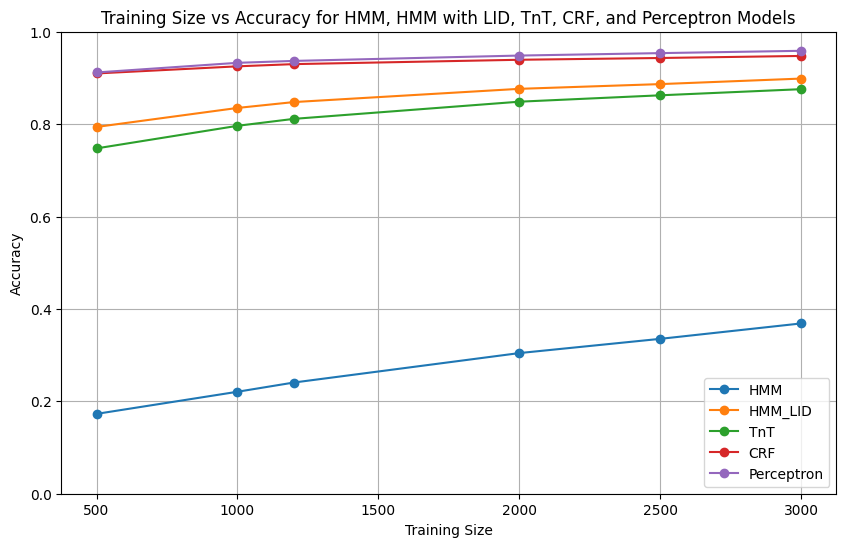

In [ ]:
plt.figure(figsize=(10, 6))

for model_name, accuracies in results.items():
    plt.plot(train_sizes, accuracies, marker='o', label=model_name)

plt.title("Training Size vs Accuracy for HMM, HMM with LID, TnT, CRF, and Perceptron Models")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc='best')
plt.grid(True)

plt.show()

### Plotting training and inference time

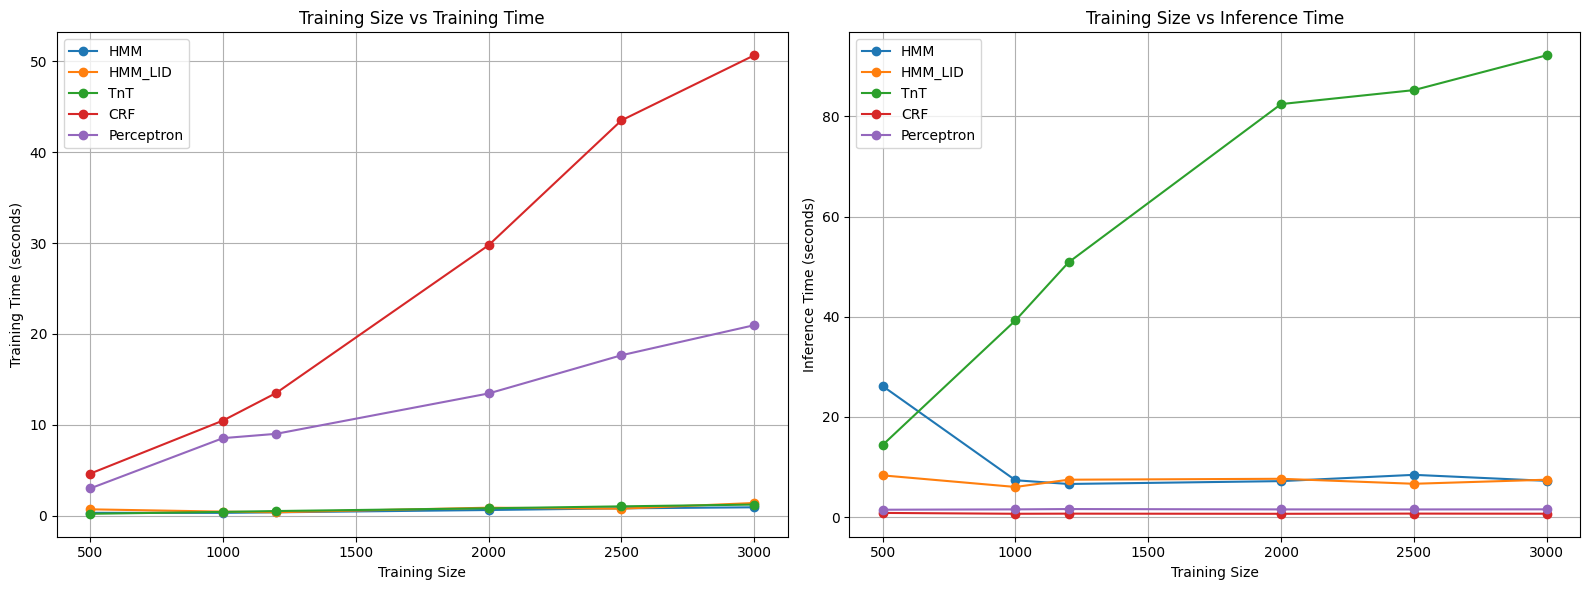

In [ ]:
# note: y axis are not the same because we compare between models between plots, and this permits a better visualisation.

fig, ax = plt.subplots(1, 2, figsize=(16, 6))


# training times
for model_name, times in training_times.items():
    ax[0].plot(train_sizes, times, marker='o', label=model_name)

ax[0].set_title("Training Size vs Training Time")
ax[0].set_xlabel("Training Size")
ax[0].set_ylabel("Training Time (seconds)")
ax[0].legend(loc='best')
ax[0].grid(True)

# inference times
for model_name, times in inference_times.items():
    ax[1].plot(train_sizes, times, marker='o', label=model_name)

ax[1].set_title("Training Size vs Inference Time")
ax[1].set_xlabel("Training Size")
ax[1].set_ylabel("Inference Time (seconds)")
ax[1].legend(loc='best')
ax[1].grid(True)


plt.tight_layout()
plt.show()

## Analysis

**Which model would you select? Justify the answer.**

Taking into consideration accuracy, training time and inference time we would selct HMM with LID smoothing, or if we can permit the training time, Perceptron. The other models are discarded because:
- Vanila HMM achieves suboptimal accuracy because of underflows.
- TnT has too big an inference time, specially considering it performs slightly worse than (some) other models regarding accuracy.
- CRF has about the same accuracy as the Perceptron, but it scales worse whent training with more data.

On the other hand, HMM with LID smoothing achieves a good accuracy with very low training and inference times. Moreover, Perceptron achieves a slightly better accuracy with about the same inference time, but takes longer to train; given such training only has to be performed once, where permissible this would be preferable.